# Heart Disease - Soft Voting Classifications

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score


In [18]:
data = pd.read_csv('heart.csv')
print('Shape of the data is ', data.shape)

Shape of the data is  (303, 14)


In [19]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [20]:
#Train test split
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
#Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
class LogisticBootstrap():
    ''' 
        Class to implement bootstrap aggregation for logistic regression on binary variable.
        The aggregation can be done by hard voting or soft voting.
    '''

    def __init__(self, n_models):
        self.n_models = n_models
        self.models = []
        self.predictions = None

    def fit(self, X_train, y_train):
        '''
            Method to fit the logistic regression models on the bootstrapped data.
        '''
        for i in range(self.n_models):
            model = LogisticRegression()
            X_train_boot, y_train_boot = resample(X_train, y_train, n_samples=int(0.3*X_train.shape[0]), random_state=i)
            model.fit(X_train_boot, y_train_boot)
            self.models.append(model)
    
    def predict_probabilities(self, X_test):
        '''
            Given the fitted models, this method computes the probabilities
            of the arrays contained in X_test to be classified as 1.
        '''
        self.n_samples = X_test.shape[0]
        self.predictions = np.zeros((self.n_models, self.n_samples))
        for i, model in enumerate(self.models):
            self.predictions[i] = model.predict_proba(X_test)[:, 1]

    
    def hard_voting(self, X_test):
        '''
            This method performs hard voting on the predictions of the models.
        '''
        self.predict_probabilities(X_test)
        hard_votes = np.round(self.predictions).astype(int)
        votes = np.round(np.sum(hard_votes, axis=0)/self.n_models).astype(int)
        return votes
    
    def soft_voting(self, X_test):
        '''
            This method performs soft voting on the predictions of the models.
        '''
        self.predict_probabilities(X_test)
        soft_votes = self.predictions
        votes = np.round(np.sum(soft_votes, axis=0)/self.n_models).astype(int)
        return votes

In [22]:
LB = LogisticBootstrap(4)
LB.fit(X_train_scaled, y_train)
y_pred_h = LB.hard_voting(X_test_scaled)
y_pred_s = LB.soft_voting(X_test_scaled)

In [23]:
#Pricision, Recall and F1 score for both the methods
print('Hard voting precision score: ', precision_score(y_test, y_pred_h))
print('Hard voting recall score: ', recall_score(y_test, y_pred_h))
print('Hard voting f1 score: ', f1_score(y_test, y_pred_h))
print('Soft voting precision score: ', precision_score(y_test, y_pred_s))
print('Soft voting recall score: ', recall_score(y_test, y_pred_s))
print('Soft voting f1 score: ', f1_score(y_test, y_pred_s))

Hard voting precision score:  0.84375
Hard voting recall score:  0.8181818181818182
Hard voting f1 score:  0.8307692307692308
Soft voting precision score:  0.7692307692307693
Soft voting recall score:  0.9090909090909091
Soft voting f1 score:  0.8333333333333333


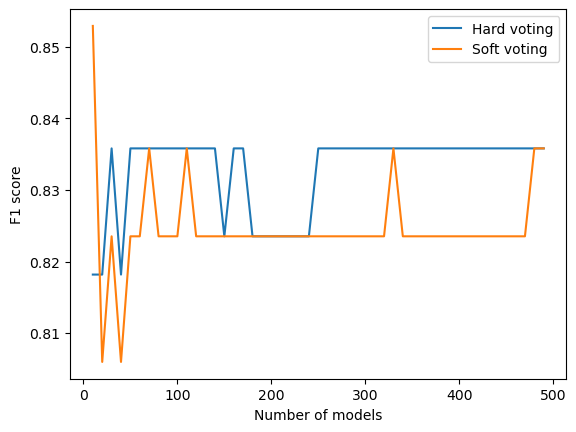

In [24]:
# Plot the f1 score when the number of model is varied from 1 to 100
import matplotlib.pyplot as plt
f1_scores_h = []
f1_scores_s = []
r = range(10, 500, 10)
for i in r:
    LB = LogisticBootstrap(i)
    LB.fit(X_train_scaled, y_train)
    y_pred_h = LB.hard_voting(X_test_scaled)
    y_pred_s = LB.soft_voting(X_test_scaled)
    f1_scores_h.append(f1_score(y_test, y_pred_h))
    f1_scores_s.append(f1_score(y_test, y_pred_s))

plt.plot(r, f1_scores_h, label='Hard voting')
plt.plot(r, f1_scores_s, label='Soft voting')
plt.xlabel('Number of models')
plt.ylabel('F1 score')
plt.legend()
plt.show()